# 03 — Speed of Market Reaction (RQ2)

**Research Question:** How quickly does each stock respond to a rate decision — does the market reprice immediately (Day 1–5) or does the full impact unfold over weeks? Does Tesla react faster than Microsoft?

**Method:** Build event windows around each hike, compute average cumulative abnormal returns per day, and identify peak drop timing per stock.

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from src.data_fetcher import (
    fetch_stock_prices,
    load_fomc_events,
    get_hike_events,
    MAG7_TICKERS,
)
from src.speed_analysis import (
    build_event_windows,
    compute_peak_drop,
    build_heatmap_data,
    build_full_window_heatmap,
    export_event_study_data,
)

sns.set_theme(style='whitegrid')
%matplotlib inline

## 1. Load Data & Build Event Windows

In [2]:
prices = fetch_stock_prices()
fomc = load_fomc_events()
hikes = get_hike_events(fomc)
hike_dates = hikes['date'].tolist()

event_windows = build_event_windows(prices, hike_dates, pre=10, post=30)

# Filter to Mag 7 only
event_windows = event_windows[event_windows['ticker'].isin(MAG7_TICKERS)]

print(f"Event window rows: {len(event_windows):,}")
print(f"Tickers: {sorted(event_windows['ticker'].unique())}")
print(f"Day range: {event_windows['day'].min()} to {event_windows['day'].max()}")
print(f"Events: {event_windows['event_date'].nunique()}")
event_windows.head(10)

[*********************100%***********************]  9 of 9 completed


Event window rows: 5,740
Tickers: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']
Day range: -10 to 30
Events: 20


,event_date,ticker,day,cum_return,benchmark_return,abnormal_return,trade_date
0,2015-12-16,AAPL,-10,0.044369,0.003106,0.041262,2015-12-02
1,2015-12-16,AMZN,-10,0.000355,0.003106,-0.002751,2015-12-02
2,2015-12-16,GOOGL,-10,0.001623,0.003106,-0.001484,2015-12-02
3,2015-12-16,META,-10,-0.006742,0.003106,-0.009849,2015-12-02
4,2015-12-16,MSFT,-10,-0.016391,0.003106,-0.019497,2015-12-02
5,2015-12-16,NVDA,-10,-0.020199,0.003106,-0.023305,2015-12-02
6,2015-12-16,TSLA,-10,-0.010746,0.003106,-0.013852,2015-12-02
8,2015-12-16,AAPL,-9,0.034669,-0.011312,0.045980,2015-12-03
9,2015-12-16,AMZN,-9,-0.014088,-0.011312,-0.002776,2015-12-03
10,2015-12-16,GOOGL,-9,-0.010804,-0.011312,0.000508,2015-12-03


## 2. Post-Hike Heatmap

Stocks (rows) x Days post-hike (columns). Color = average cumulative abnormal return.
Red = stock underperforming market, Green = outperforming.

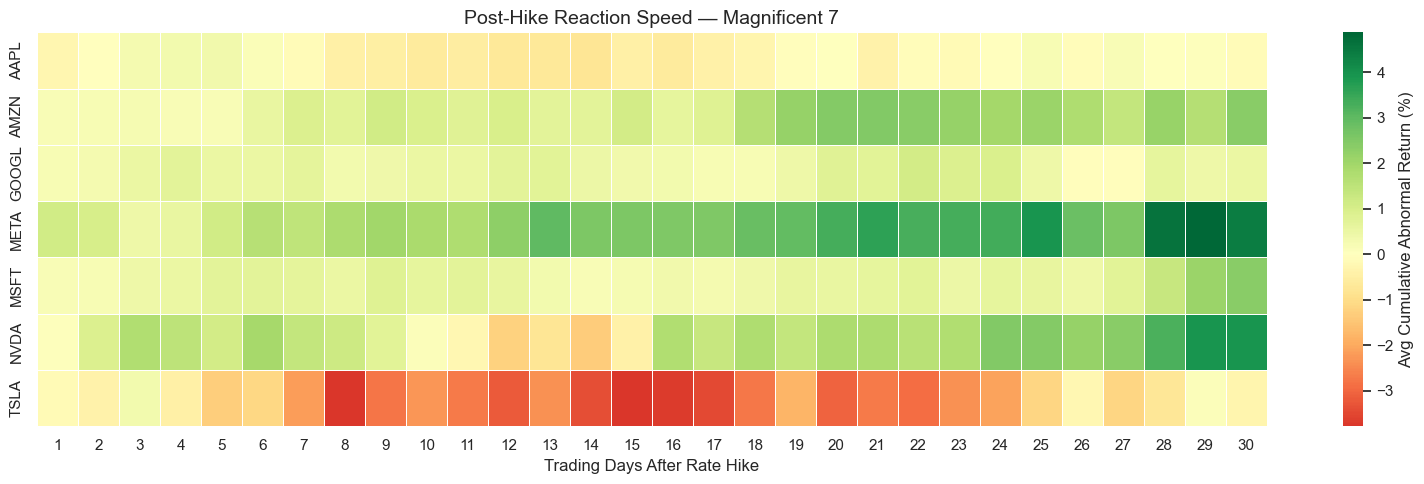

In [3]:
heatmap_data = build_heatmap_data(event_windows)

fig, ax = plt.subplots(figsize=(16, 5))

sns.heatmap(
    heatmap_data * 100,
    cmap='RdYlGn',
    center=0,
    annot=False,
    fmt='.1f',
    linewidths=0.5,
    cbar_kws={'label': 'Avg Cumulative Abnormal Return (%)'},
    ax=ax,
)

ax.set_title('Post-Hike Reaction Speed — Magnificent 7', fontsize=14)
ax.set_xlabel('Trading Days After Rate Hike')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

## 3. Full Event Window (Pre + Post)

Including 10 pre-event days to see if stocks move *before* the announcement (market anticipation).

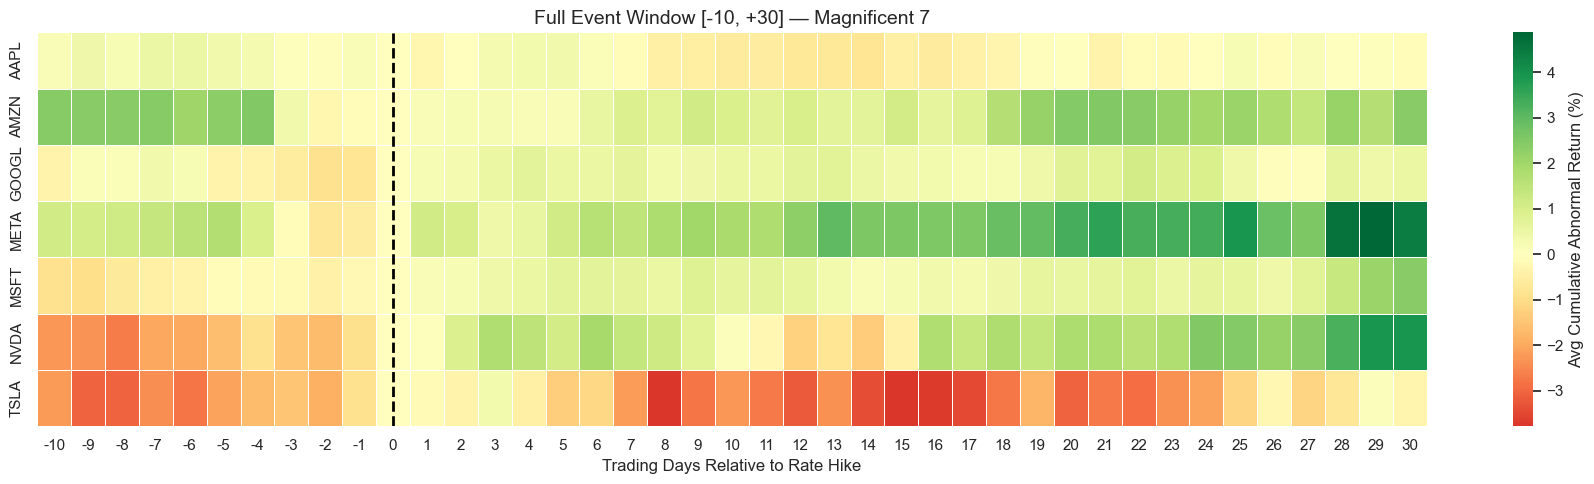

In [4]:
full_heatmap = build_full_window_heatmap(event_windows)

fig, ax = plt.subplots(figsize=(18, 5))

sns.heatmap(
    full_heatmap * 100,
    cmap='RdYlGn',
    center=0,
    annot=False,
    linewidths=0.5,
    cbar_kws={'label': 'Avg Cumulative Abnormal Return (%)'},
    ax=ax,
)

# Mark Day 0 with a vertical line
day_cols = list(full_heatmap.columns)
if 0 in day_cols:
    zero_pos = day_cols.index(0)
    ax.axvline(x=zero_pos + 0.5, color='black', linewidth=2, linestyle='--', label='Event Day')

ax.set_title('Full Event Window [-10, +30] — Magnificent 7', fontsize=14)
ax.set_xlabel('Trading Days Relative to Rate Hike')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

## 4. Peak Drop Day Analysis

On which day post-hike does each stock typically hit its maximum drawdown?

In [5]:
peak_drop = compute_peak_drop(event_windows)
print("=== Peak Drop Day per Stock (averaged across all hike events) ===")
print("Sorted by speed: fastest reactors first\n")
peak_drop

=== Peak Drop Day per Stock (averaged across all hike events) ===
Sorted by speed: fastest reactors first



,ticker,avg_peak_drop_day,median_peak_drop_day,avg_peak_drop_return,n_events
1,AMZN,13.00,11.5,-0.052610,20
5,NVDA,14.00,13.5,-0.086199,20
6,TSLA,14.35,14.5,-0.131458,20
4,MSFT,14.70,13.5,-0.028390,20
0,AAPL,14.80,13.5,-0.039840,20
3,META,14.85,12.0,-0.057895,20
2,GOOGL,15.95,14.5,-0.042298,20


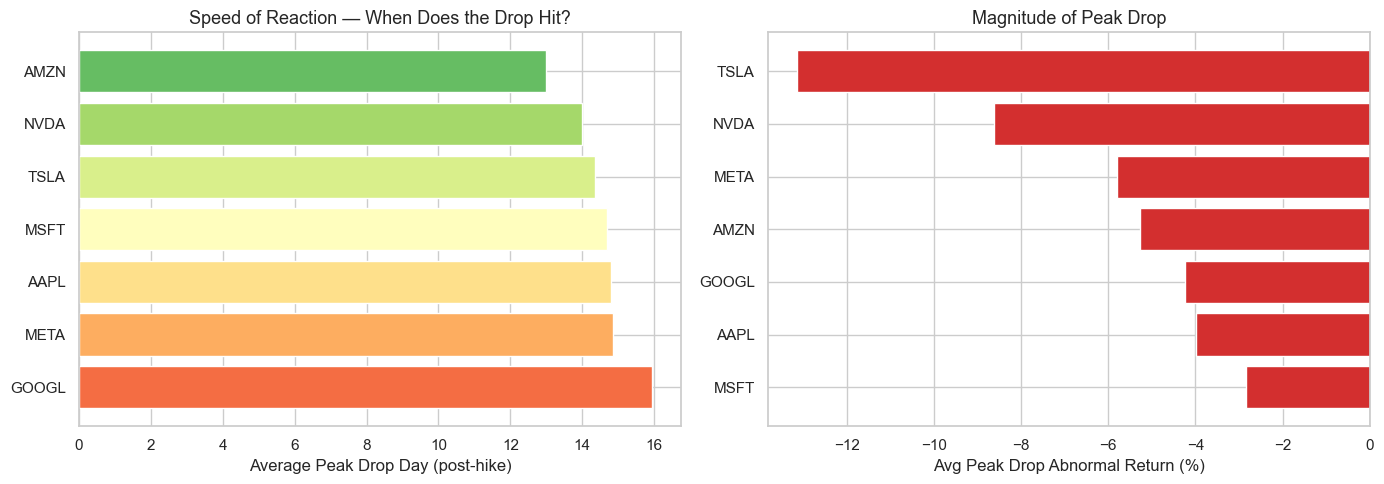

In [6]:
# Peak drop day comparison chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: average peak drop day
peak_sorted = peak_drop.sort_values('avg_peak_drop_day')
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(peak_sorted)))
ax1.barh(peak_sorted['ticker'], peak_sorted['avg_peak_drop_day'], color=colors)
ax1.set_xlabel('Average Peak Drop Day (post-hike)')
ax1.set_title('Speed of Reaction — When Does the Drop Hit?', fontsize=13)
ax1.invert_yaxis()

# Right: average peak drop magnitude
peak_by_mag = peak_drop.sort_values('avg_peak_drop_return')
colors_mag = ['#d32f2f' if v < 0 else '#388e3c' for v in peak_by_mag['avg_peak_drop_return']]
ax2.barh(peak_by_mag['ticker'], peak_by_mag['avg_peak_drop_return'] * 100, color=colors_mag)
ax2.axvline(x=0, color='black', linewidth=0.8)
ax2.set_xlabel('Avg Peak Drop Abnormal Return (%)')
ax2.set_title('Magnitude of Peak Drop', fontsize=13)
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

## 5. Reaction Trajectory — Line Chart

Average cumulative abnormal return trajectory for each stock from Day -10 to Day +30.

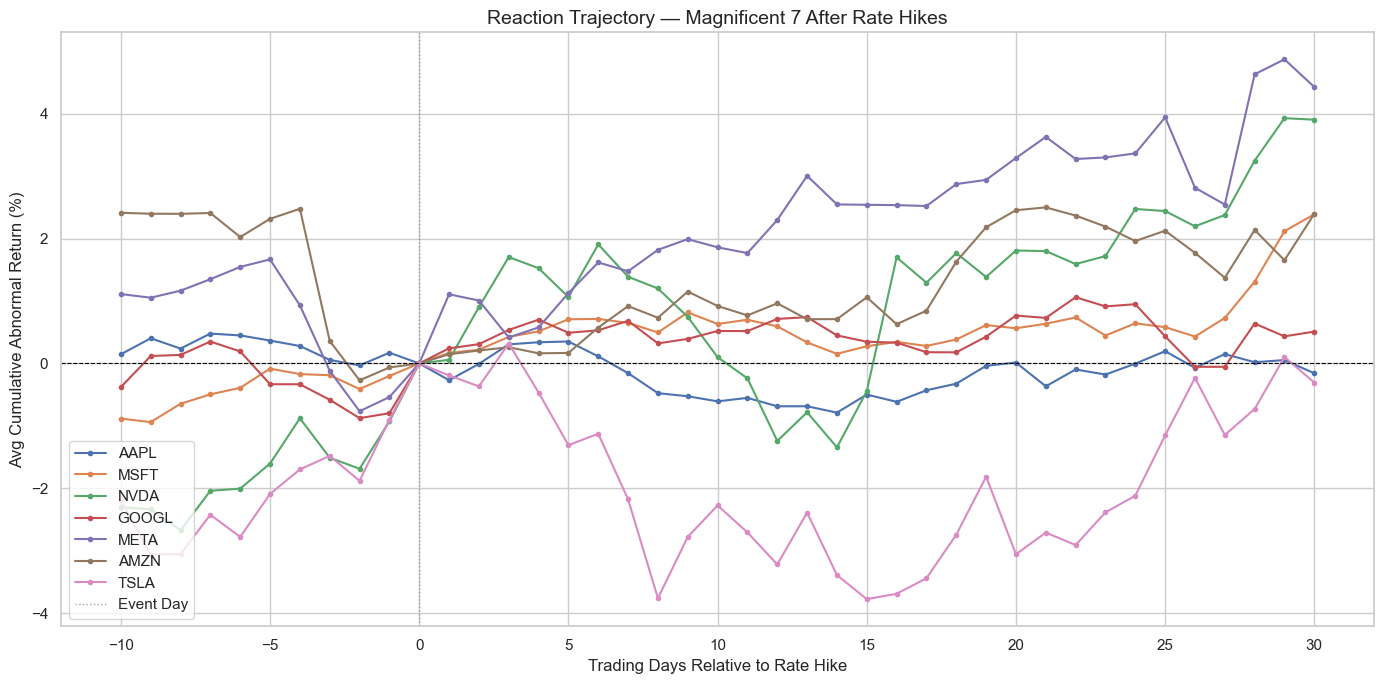

In [7]:
fig, ax = plt.subplots(figsize=(14, 7))

for ticker in MAG7_TICKERS:
    ticker_data = event_windows[event_windows['ticker'] == ticker]
    trajectory = ticker_data.groupby('day')['abnormal_return'].mean()
    ax.plot(trajectory.index, trajectory.values * 100, marker='.', linewidth=1.5, label=ticker)

ax.axhline(y=0, color='black', linewidth=0.8, linestyle='--')
ax.axvline(x=0, color='gray', linewidth=1, linestyle=':', alpha=0.7, label='Event Day')
ax.set_xlabel('Trading Days Relative to Rate Hike')
ax.set_ylabel('Avg Cumulative Abnormal Return (%)')
ax.set_title('Reaction Trajectory — Magnificent 7 After Rate Hikes', fontsize=14)
ax.legend(loc='lower left')
plt.tight_layout()
plt.show()

## 6. Key Insights

In [8]:
fastest = peak_drop.iloc[0]
slowest = peak_drop.iloc[-1]
deepest = peak_drop.sort_values('avg_peak_drop_return').iloc[0]

print("=== Key Insights ===")
print(f"Fastest reactor: {fastest['ticker']} — peak drop at Day {fastest['avg_peak_drop_day']:.1f}")
print(f"Slowest reactor: {slowest['ticker']} — peak drop at Day {slowest['avg_peak_drop_day']:.1f}")
print(f"Deepest drop:    {deepest['ticker']} — avg peak abnormal return of {deepest['avg_peak_drop_return']*100:.2f}%")
print(f"\nDay spread: {slowest['avg_peak_drop_day'] - fastest['avg_peak_drop_day']:.1f} trading days between fastest and slowest reactor")

=== Key Insights ===
Fastest reactor: AMZN — peak drop at Day 13.0
Slowest reactor: GOOGL — peak drop at Day 15.9
Deepest drop:    TSLA — avg peak abnormal return of -13.15%

Day spread: 2.9 trading days between fastest and slowest reactor


## 7. Export for Tableau

In [9]:
export_event_study_data(event_windows)

Exported 5,740 rows to /Users/thedarianwong/Developer/bigtech-fed-analysis/output/event_study.csv
